In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

sns.set()

In [2]:
# setear a True para entrenar todos  
long_run = False

# Ensembles: bagging, boosting, stacking y voting

Usamos el dataset [**Banknote Authentication Data Set**](http://archive.ics.uci.edu/ml/datasets/banknote+authentication), en cual tiene 4 variables de distintos billetes: billetes falsos y billetes auténticos. La idea es clasificar los billetes según esas cuatro variables para detectar los billetes falsos.

<img src="data/img1.png" alt="Drawing" style="width: 800px;"/>
Imagen obtenida de:https://www.researchgate.net/publication/266673146_Banknote_Authentication

La idea es realizando una transformada a las imágenes (particularmente wavelet transform) se mide que tan "difusa" es la imagen, ya que si se grafica el histograma normalizado de los coeficientes de dicha transformada se tiene:

<img src="data/img2.png" alt="Drawing" style="width: 800px;"/>
Imagen obtenida de:https://www.researchgate.net/publication/266673146_Banknote_Authentication

In [3]:
dataset = pd.read_csv(
    "https://drive.google.com/uc?export=download&id=1QwdtiOXuINHjb-XvGjXIGe6D35TRvEpA",
    header=None,
)

In [4]:
dataset.columns = ["variance", "skew", "curtosis", "entropy", "target"]

In [5]:
dataset.head()

,variance,skew,curtosis,entropy,target
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


# Graficamos los histogramas de las variables de forma explorativa:

Text(0.5, 1.0, 'Entropy')

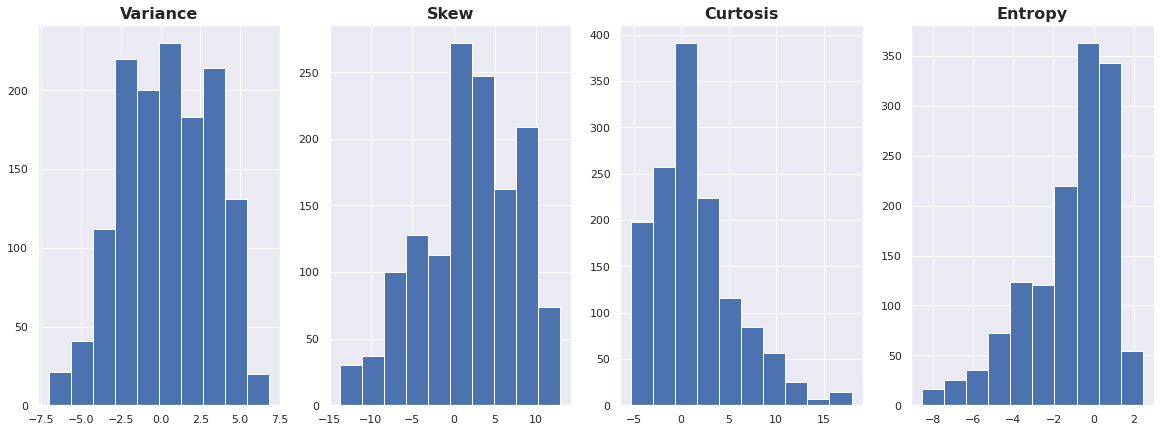

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 7))
ax1.hist(dataset["variance"])
ax1.set_title("Variance", weight="bold", fontsize=16)
ax2.hist(dataset["skew"])
ax2.set_title("Skew", weight="bold", fontsize=16)
ax3.hist(dataset["curtosis"])
ax3.set_title("Curtosis", weight="bold", fontsize=16)
ax4.hist(dataset["entropy"])
ax4.set_title("Entropy", weight="bold", fontsize=16)

# Ahora graficamos dos de las variables y la variable target:

/opt/hostedtoolcache/Python/3.7.11/x64/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


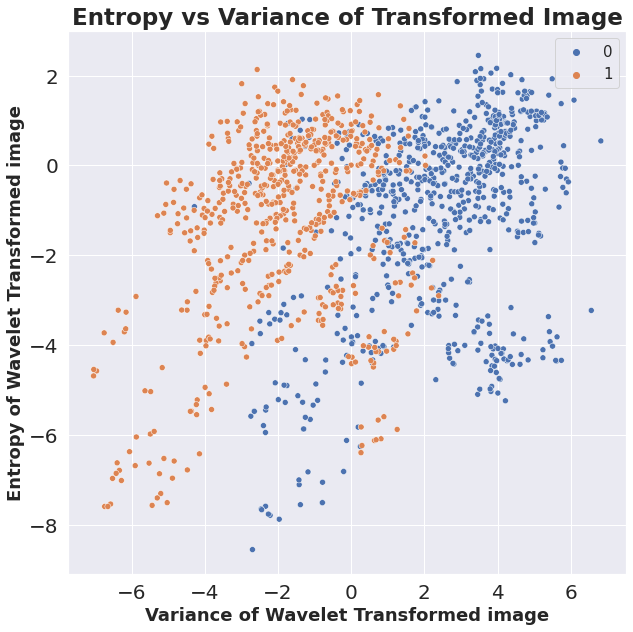

In [7]:
plt.figure(figsize=(10, 10))
g = sns.scatterplot(dataset['variance'], dataset['entropy'], hue=dataset["target"])
ax = g.axes
ax.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Variance of Wavelet Transformed image', fontsize=18, fontweight='bold')
plt.ylabel('Entropy of Wavelet Transformed image', fontsize=18, fontweight='bold')
plt.legend(prop={'size': 15})
plt.title("Entropy vs Variance of Transformed Image", fontsize=23, fontweight="bold")
plt.show()

Vemos que usando estas dos variables, las clases están bastante separadas. Tienen, sin embargo, una zona en la que se solapan las dos clases.

## Árbol de decisión

El primer modelo que vamos a probar será un **árbol de decisión**, recordamos que lo que hace el árbol es dividir el espacio de predictores, por ejemplo:

/opt/hostedtoolcache/Python/3.7.11/x64/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


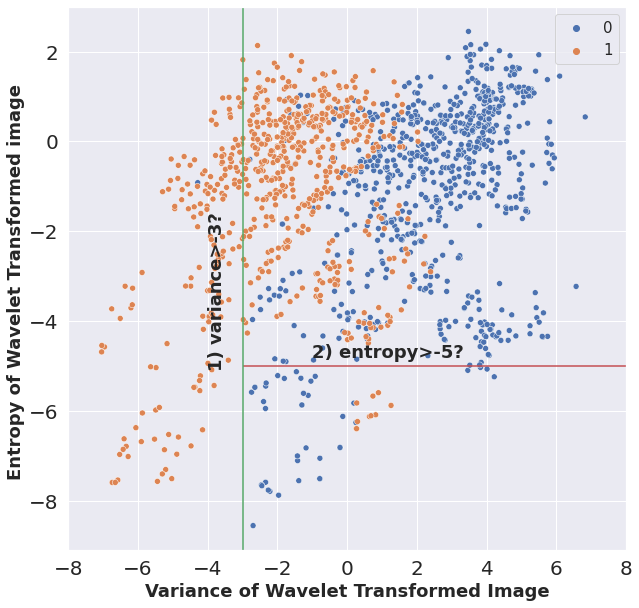

In [8]:
plt.figure(figsize=(10, 10))
g = sns.scatterplot(dataset['variance'], dataset['entropy'], hue=dataset['target'])
ax = g.axes
ax.hlines(-5, xmin=-3, xmax=8, color='r')
ax.axvline(-3, color='g')
ax.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Variance of Wavelet Transformed Image', fontsize=18, fontweight='bold')
plt.ylabel('Entropy of Wavelet Transformed image ', fontsize=18, fontweight='bold')
plt.legend(prop={'size': 15})
plt.xlim(-8, +8)
plt.text(-4, -5, "1) variance>-3?", fontsize=18, fontweight='bold', rotation=90)
plt.text(-1, -4.8, "2) entropy>-5?", fontsize=18, fontweight='bold')
plt.show()

# Vemos que tipo de datos tiene cada columna:

In [9]:
dataset.dtypes

variance    float64
skew        float64
curtosis    float64
entropy     float64
target        int64
dtype: object

In [10]:
dataset.target.value_counts()

0    762
1    610
Name: target, dtype: int64

Notamos que queremos hacer una **clasificación** ya que la variable target es billete trucho o real.

Separamos los datos en variables de entrada para los modelos y variable target:

In [11]:
x_columns = ['variance', 'skew', 'curtosis', 'entropy']

In [12]:
x_data = dataset[x_columns]
y_data = dataset['target']

Usamos la *train_test_split* que nos divide el dataset en set de entrenamiento y set de validacion agarrando valores aleatorios de nuestro dataset.

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(
    x_data, y_data, test_size=0.4, random_state=66
)

### DecisionTreeClassifier
Primero empezamos con el modelo más simple de árbol que es el [**DecisionTreeClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) de sklearn.

In [14]:
from sklearn.tree import DecisionTreeClassifier

Como las clases parecen ser fácilmente separables vamos a imponerle al árbol una profundidad máxima de 3. Usamos como criterio para la división la entropía:

In [15]:
model_tree = DecisionTreeClassifier(max_depth=3, criterion="entropy")

Entrenamos el modelo pasándole los datos de entrenamiento

In [16]:
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

Importamos la función accuracy_score quecalcula la precisión del modelo

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
pred = model_tree.predict(X_validation)

El método predict me devuelve las clases (si usamos modelos tipo clasificadores)

In [19]:
pred[:10]

array([0, 0, 1, 1, 0, 0, 0, 0, 1, 0])

In [20]:
decision_tree_acc = accuracy_score(pred, y_validation)
decision_tree_acc

0.9234972677595629

Vemos que el modelo tiene un 92% de accuracy en el validation set, ahora imprimamos el árbol, para ello usamos la herramienta plot_tree:

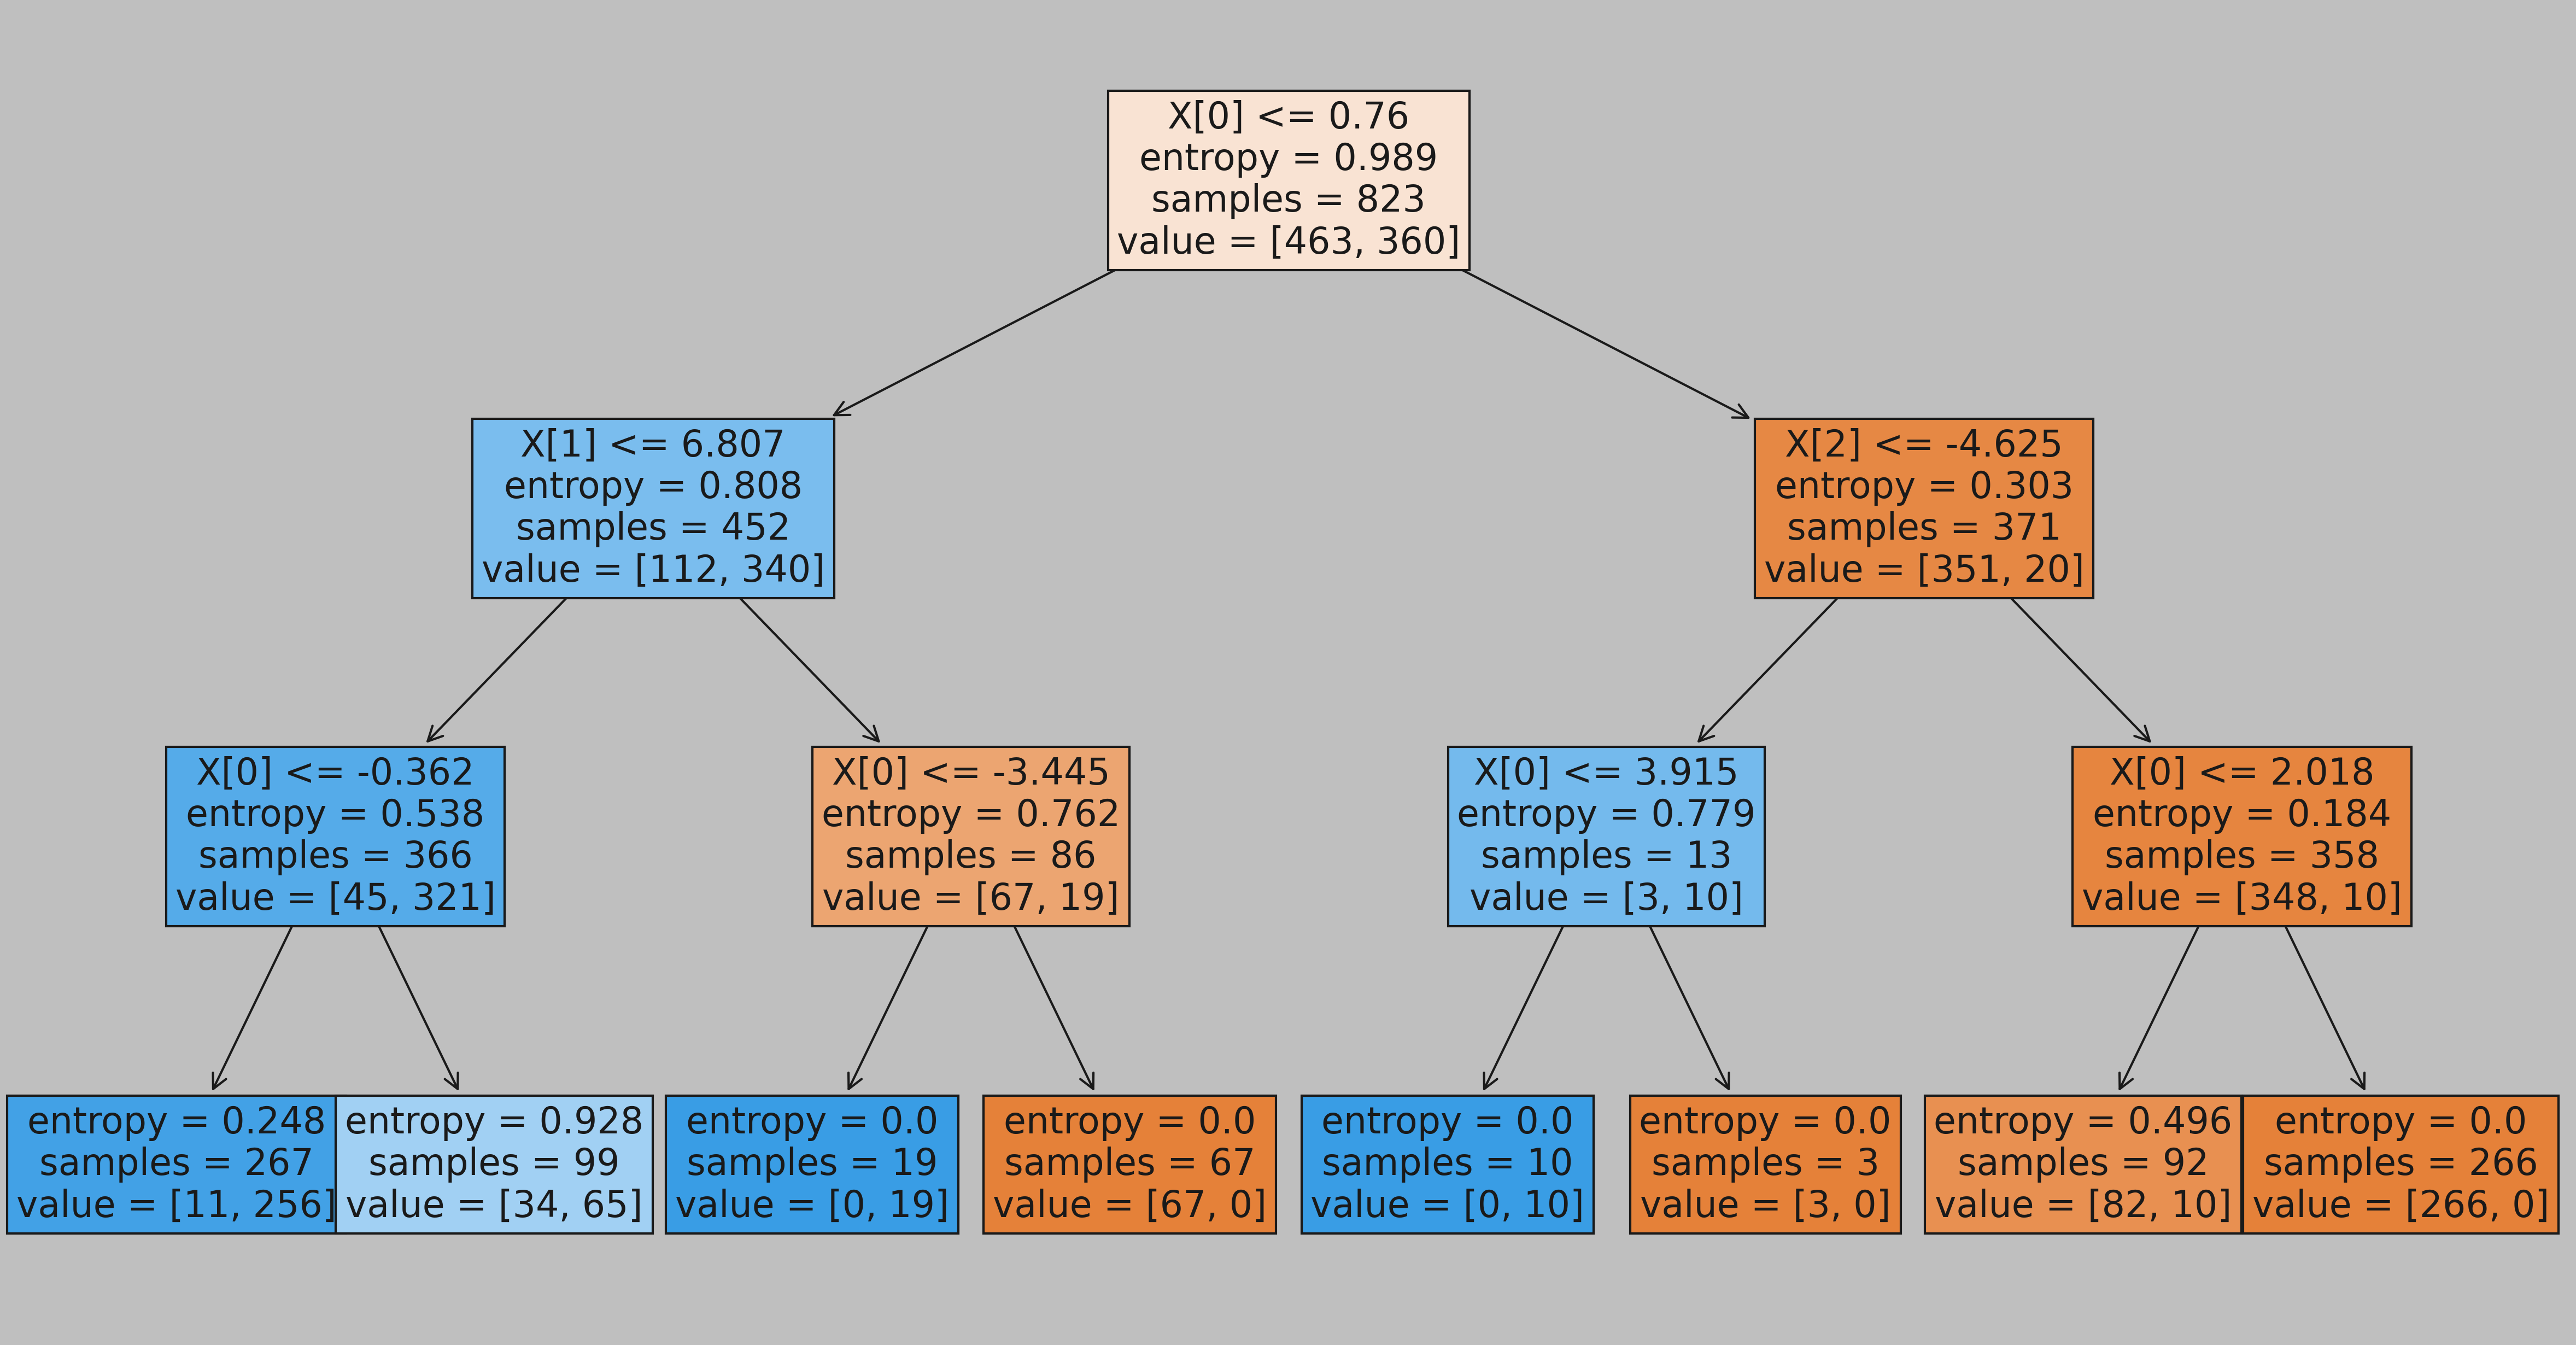

In [21]:
from sklearn.tree import plot_tree

with plt.style.context("classic"):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10), dpi=300)
    plot_tree(model_tree, filled=True, fontsize=16)

Para cada nodo nos da el test que hace, la cantidad de datos para cada clase y la entropía del conjunto.

## BaggingClassifier

Ahora vamos con un modelo que usa la técnica de bagging. Para ello usamos [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) de sklean.
Recordemos en la técnica de bagging se toman subsets random de los datos para entrenar el modelo. Particularmente el estimador base de BaggingClassifier por default es un árbol de decisión, particularmente entrena 10 estimadores.

In [22]:
from sklearn.ensemble import BaggingClassifier

In [23]:
model_bagging = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3, criterion="entropy")
)

In [24]:
model_bagging.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_depth=3))

In [25]:
pred_bagging = model_bagging.predict(X_validation)

In [26]:
bagging_tree_acc = accuracy_score(pred_bagging, y_validation)
bagging_tree_acc

0.9617486338797814

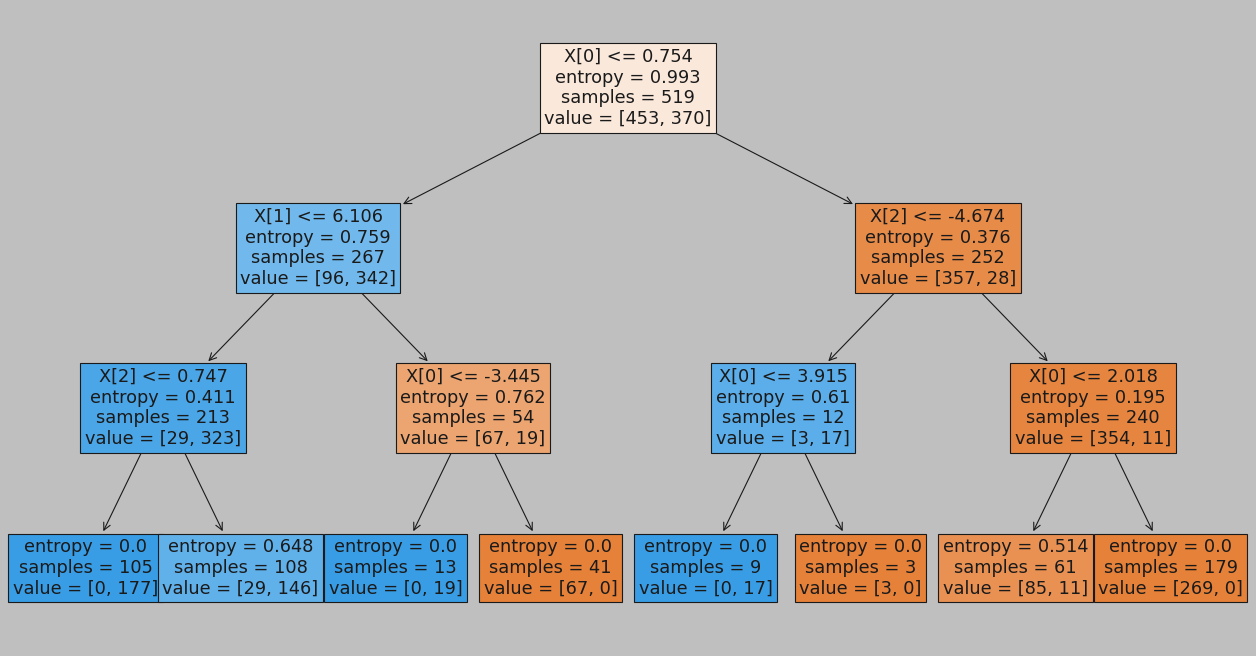

In [27]:
with plt.style.context("classic"):
    plt.figure(figsize=(20, 10))
    plot_tree(model_bagging.estimators_[0], filled=True, fontsize=16)

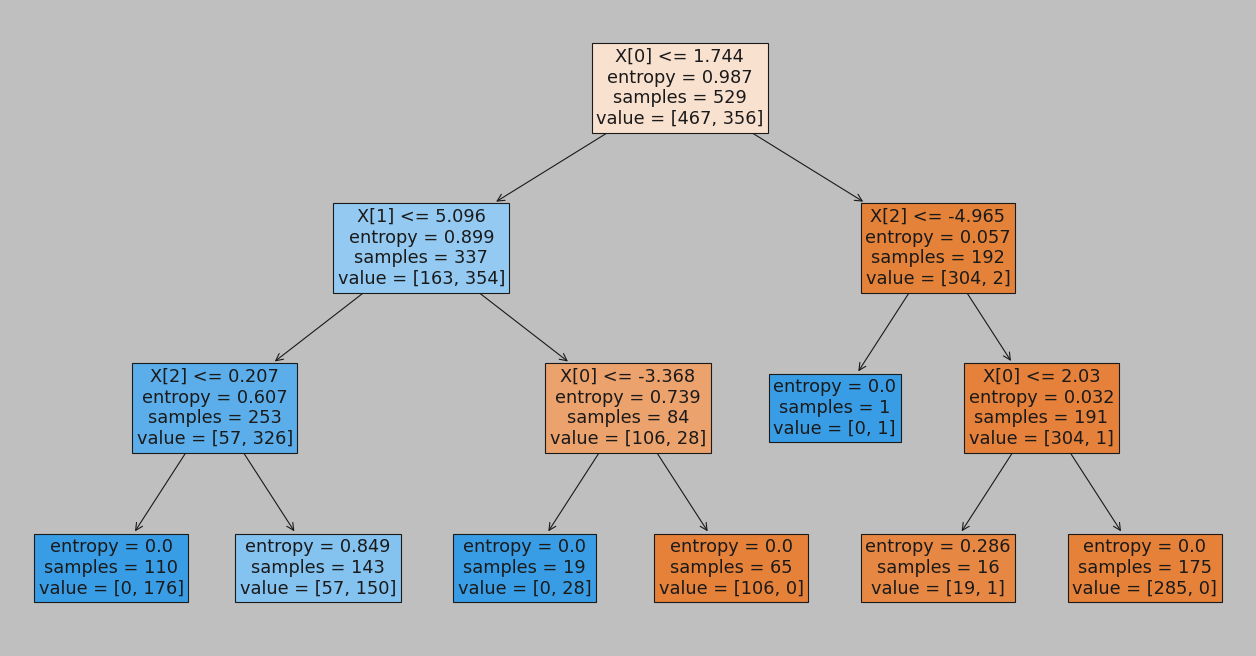

In [28]:
with plt.style.context("classic"):
    plt.figure(figsize=(20, 10))
    plot_tree(model_bagging.estimators_[1], filled=True, fontsize=16)

Imprimimos el estimador del primer nodo de los 10 árboles:

In [29]:
for tree in model_bagging.estimators_:
    print(tree.tree_.feature[0])

0
0
0
0
0
0
0
0
0
0


Vemos que el **primer nodo de todos los árboles es la misma variable predictora**. De alguna manera los árboles se encuentran **relacionados (empiezan con la misma estructura)**. Por lo que una forma de **reducir la varianza** es **evitar que la estructura de los árboles sea parecida** tomando un **subset de las variables predictoras de entrada** y hacer el split con una de ellas. De esta manera se evita tomar siempre la misma variable para un dado nodo en todos los modelos. El modelo a continuación llamado **Random Forest** usa esta técnica.

## RandomForestClassifier

Usamos un modelo de clasificador del tipo **Random Forest**, importando [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) de sklearn. Dejamos todos los parámteros por default excepto la profundidad de los árboles, la cual le damos el valor de 3.

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
model_rfr = RandomForestClassifier(max_depth=3)

Entrenamos el modelo.

In [32]:
model_rfr.fit(X_train, y_train)  # predictions

RandomForestClassifier(max_depth=3)

In [33]:
pred_rfr = model_rfr.predict(X_validation)

In [34]:
random_forest_acc = accuracy_score(pred_rfr, y_validation)
random_forest_acc

0.9562841530054644

Vemos que el accuracy en el validation set es de 96%. Recordemos que el modelo de Random Forest son un conjunto de árboles.

In [35]:
len(model_rfr.estimators_)

100

En este caso el valor default de arboles entrenados es 100. Imprimiendo el primer árbol:

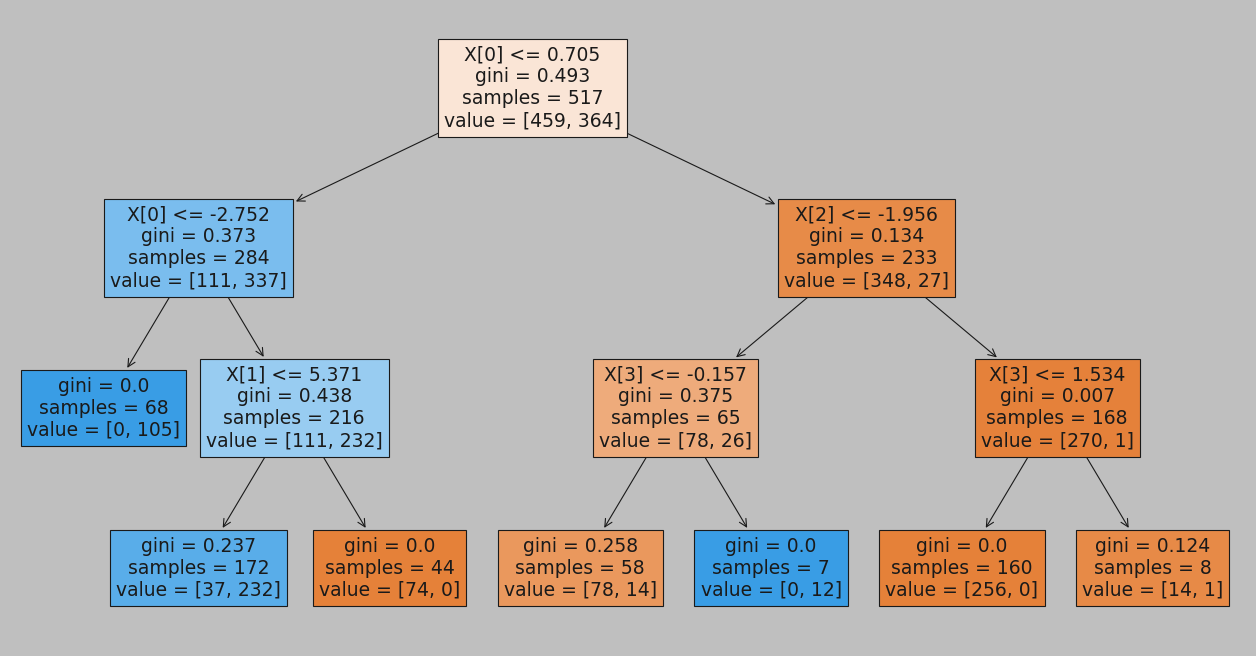

In [36]:
with plt.style.context("classic"):
    plt.figure(figsize=(20, 10))
    plot_tree(model_rfr.estimators_[0], filled=True)

In [37]:
for tree in model_rfr.estimators_[:10]:
    print(tree.tree_.feature[0])

0
1
1
1
1
1
0
0
0
0


Vemos que **la estructura de los árboles es distinta**, por lo que los modelos están **menos correlacionados**, teniendo menos varianza.

Recordando que la idea es promediar muchos modelos, cual es el accuracy de los modelos de árboles de decisión por separado?

In [38]:
pred_first_estimator = model_rfr.estimators_[0].predict(X_validation)

In [39]:
accuracy_score(pred_first_estimator, y_validation)

0.9253187613843351

In [40]:
pred_estimators = [
    estimator.predict(X_validation) for estimator in model_rfr.estimators_
]
acc_estimators = [accuracy_score(pred, y_validation) for pred in pred_estimators]

Text(0.5, 1.0, 'Histograma de accuracy de los arboles del RF model')

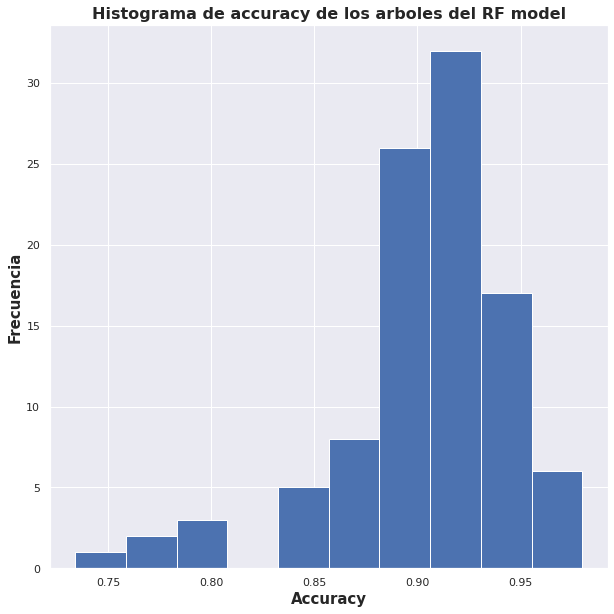

In [41]:
plt.figure(figsize=(10, 10))
plt.hist(acc_estimators)
plt.xlabel("Accuracy", weight="bold", fontsize=15)
plt.ylabel("Frecuencia", weight="bold", fontsize=15)
plt.title(
    "Histograma de accuracy de los arboles del RF model", weight="bold", fontsize=16
)

In [42]:
max(acc_estimators)

0.9799635701275046

In [43]:
min(acc_estimators)

0.7340619307832422

In [44]:
accuracy_score(pred_rfr, y_validation)

0.9562841530054644

En este caso, los 100 árboles realizan una votación y se elige la clase que salió la mayor cantidad de veces.

Otra característica del random forest es que aumentar la cantidad de estimadores (árboles) usados no aumenta el overfitting:

In [45]:
estimators = np.arange(1, 1000, 10)
pred = []
for i in estimators:
    model_rfr_ = RandomForestClassifier(n_estimators=i, max_depth=3)
    model_rfr_.fit(X_train, y_train)
    pred_estimator = model_rfr_.predict(X_validation)
    pred.append(accuracy_score(pred_estimator, y_validation))

Text(0.5, 0, '# de estimadores')

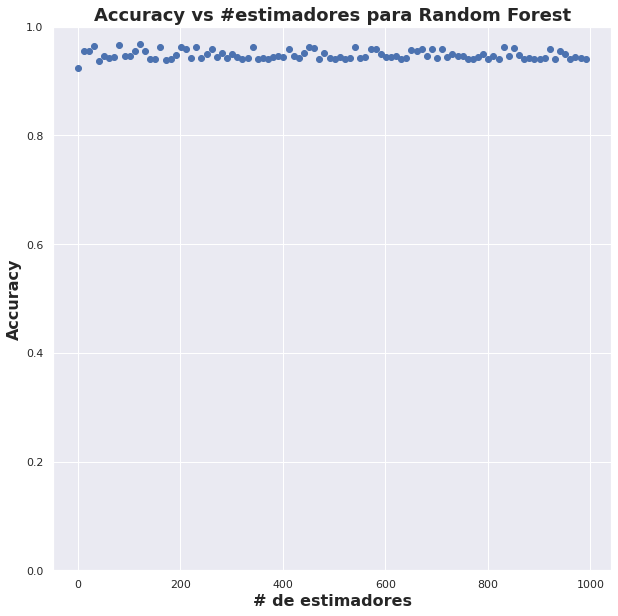

In [46]:
plt.figure(figsize=(10, 10))
plt.plot(estimators, pred, "o")
plt.ylim(0, 1)
plt.title("Accuracy vs #estimadores para Random Forest", fontsize=18, weight="bold")
plt.ylabel("Accuracy", fontsize=16, weight="bold")
plt.xlabel("# de estimadores", fontsize=16, weight="bold")

### Boosting
Ahora usamos un modelo de tipo boosting importando el modelo [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

In [48]:
model_boosting = GradientBoostingClassifier(max_depth=3)

In [49]:
model_boosting.fit(X_train, y_train)

GradientBoostingClassifier()

In [50]:
pred_gbr = model_boosting.predict(X_validation)

In [51]:
boosting_acc = accuracy_score(pred_gbr, y_validation)
boosting_acc

0.9981785063752276

In [52]:
print(
    "Accurary \nÁrbol de decisión: {:.2f} \nBagging: {:.2f} \nRandom forest: {:.2f} \nBoosting: {:.3f}".format(
        decision_tree_acc, bagging_tree_acc, random_forest_acc, boosting_acc
    )
)

Accurary 
Árbol de decisión: 0.92 
Bagging: 0.96 
Random forest: 0.96 
Boosting: 0.998


In [53]:
# Stacking y Voting

In [54]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix


def plot_confusion_mat(y_pred, y_test):

    # Calculating tyhe confusion matrix, normalized and not normalized

    cm = confusion_matrix(y_pred, y_test, labels=np.unique(y_test), normalize="true")
    cm_num = confusion_matrix(pred_knn_only, y_test, labels=np.unique(y_test))

    group_counts = ["{0:0.0f}".format(value) for value in cm_num.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(len(np.unique(y_test)), len(np.unique(y_test)))

    # plotting the matrix
    plt.figure(figsize=(10, 10), dpi=220)
    ax = sns.heatmap(cm * 100, annot=labels, annot_kws={"size": 8}, fmt='', cmap='BuPu')
    ax.set_ylim(10, 0)
    ax.set_ylabel("True label", weight="bold")
    ax.set_xlabel("Predicted label", weight="bold")
    return ax

In [55]:
sns.set()
from sklearn.preprocessing import label_binarize

from sklearn.metrics import roc_curve, auc


def roc_multiclass(test_pred, y_test, clss=0):
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], test_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure()
    lw = 2
    cl = 0
    fig, axs = plt.subplots(2, 5, figsize=(15, 10), sharex=True, sharey=True)
    for ax in axs:
        for col in ax:
            col.plot(
                fpr[cl],
                tpr[cl],
                color='darkorange',
                lw=lw,
                label='ROC class %s (AUC= %0.2f)' % (clss, roc_auc[clss]),
            )
            cl += 1
            col.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            col.set_xlim([0.0, 1.0])
            col.set_ylim([0.0, 1.05])
            col.set_title('ROC class %s' % (cl))
    axs[1, 0].set_xlabel('False Positive Rate', weight="bold")
    axs[1, 1].set_xlabel('False Positive Rate', weight="bold")
    axs[1, 2].set_xlabel('False Positive Rate', weight="bold")
    axs[1, 3].set_xlabel('False Positive Rate', weight="bold")
    axs[1, 4].set_xlabel('False Positive Rate', weight="bold")
    axs[0, 0].set_ylabel('True Positive Rate', weight="bold")
    axs[1, 0].set_ylabel('True Positive Rate', weight="bold")
    plt.subplots_adjust()
    return axs, np.mean(list(roc_auc.values()))

## [Poker Hand Data Set](https://archive.ics.uci.edu/ml/datasets/Poker+Hand)

La idea es que se tiene información de distintas manos (información de 5 cartas) y la variable target es la mano de poker, es decir, si esa mano pertenece a alguna de las siguientes categorías:

In [56]:
training_set = pd.read_csv(
    'https://drive.google.com/uc?export=download&id=1aKnKyFw5L5Wl1HAZqy3axrTM7UksHz_g',
    header=None,
)
validation_set = pd.read_csv(
    'https://drive.google.com/uc?export=download&id=1Wvfs82n6IxvNkQv5WFhHu4kWWF9bTNnC',
    header=None,
)

In [57]:
head = ["P1", "N1", "P2", "N2", "P3", "N3", "P4", "N4", "P5", "N5", "target"]

In [58]:
training_set.columns = head
training_set.head()

,P1,N1,P2,N2,P3,N3,P4,N4,P5,N5,target
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9


<img src="data/poker.jpg" alt="Drawing" style="width: 800px;"/>

Tengo por lo tanto, informacion para cada mano de las 5 cartas: su pinta(diamantes, picas, tréboles o corazones) y el valor de la misma( A, 2, 3, etc.)

La variables target es una variable categorica:
 - 0: Nothing in hand; not a recognized poker hand
 - 1: One pair; one pair of equal ranks within five cards
 - 2: Two pairs; two pairs of equal ranks within five cards
 - 3: Three of a kind; three equal ranks within five cards
 - 4: Straight; five cards, sequentially ranked with no gaps
 - 5: Flush; five cards with the same suit
 - 6: Full house; pair + different rank three of a kind
 - 7: Four of a kind; four equal ranks within five cards
 - 8: Straight flush; straight + flush
 - 9: Royal flush; {Ace, King, Queen, Jack, Ten} + flush

<img src="data/tabla.png" alt="Drawing" style="width: 600px;"/>

In [59]:
training_set["target"].value_counts(normalize=True)

0    0.499520
1    0.423790
2    0.048221
3    0.020512
4    0.003719
5    0.002159
6    0.001439
7    0.000240
9    0.000200
8    0.000200
Name: target, dtype: float64

In [60]:
len(training_set)

25010

In [61]:
len(validation_set)

1000000

In [62]:
validation_set.columns = head

In [63]:
training_set[training_set["target"] == 9]

,P1,N1,P2,N2,P3,N3,P4,N4,P5,N5,target
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9


### Stacking
Usamos el [StackingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html) de sklearn para stackear clasificadores, es decir, el output de un clasificador es el input del siguiente. Vamos a usar un clasificador del tipo [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) y un [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Vamos a evaluar los resultados usando los modelos por separados vs un stack de esos modelos.

In [64]:
x_columns = ["P1", "N1", "P2", "N2", "P3", "N3", "P4", "N4", "P5", "N5"]

In [65]:
X_train = training_set[x_columns]

In [66]:
y_train = training_set["target"]

In [67]:
X_validation = validation_set[x_columns]

In [68]:
y_validation = validation_set["target"]

In [69]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier

clf_1 = KNeighborsClassifier()
clf_2 = RandomForestClassifier()
stacking_model = StackingClassifier(estimators=[('clf_1', clf_1), ('clf_2', clf_2)])

Entrenamos un modelo usando solo un clasificador de tipo knn:

In [70]:
knn_only = KNeighborsClassifier()
knn_only.fit(X_train, y_train)

KNeighborsClassifier()

In [71]:
pred_knn_only = knn_only.predict(X_validation)

In [72]:
accuracy_score(pred_knn_only, y_validation)

0.552178

Imprimimos la confusion matrix multiclase (+ de 2 clases)

<AxesSubplot:xlabel='Predicted label', ylabel='True label'>

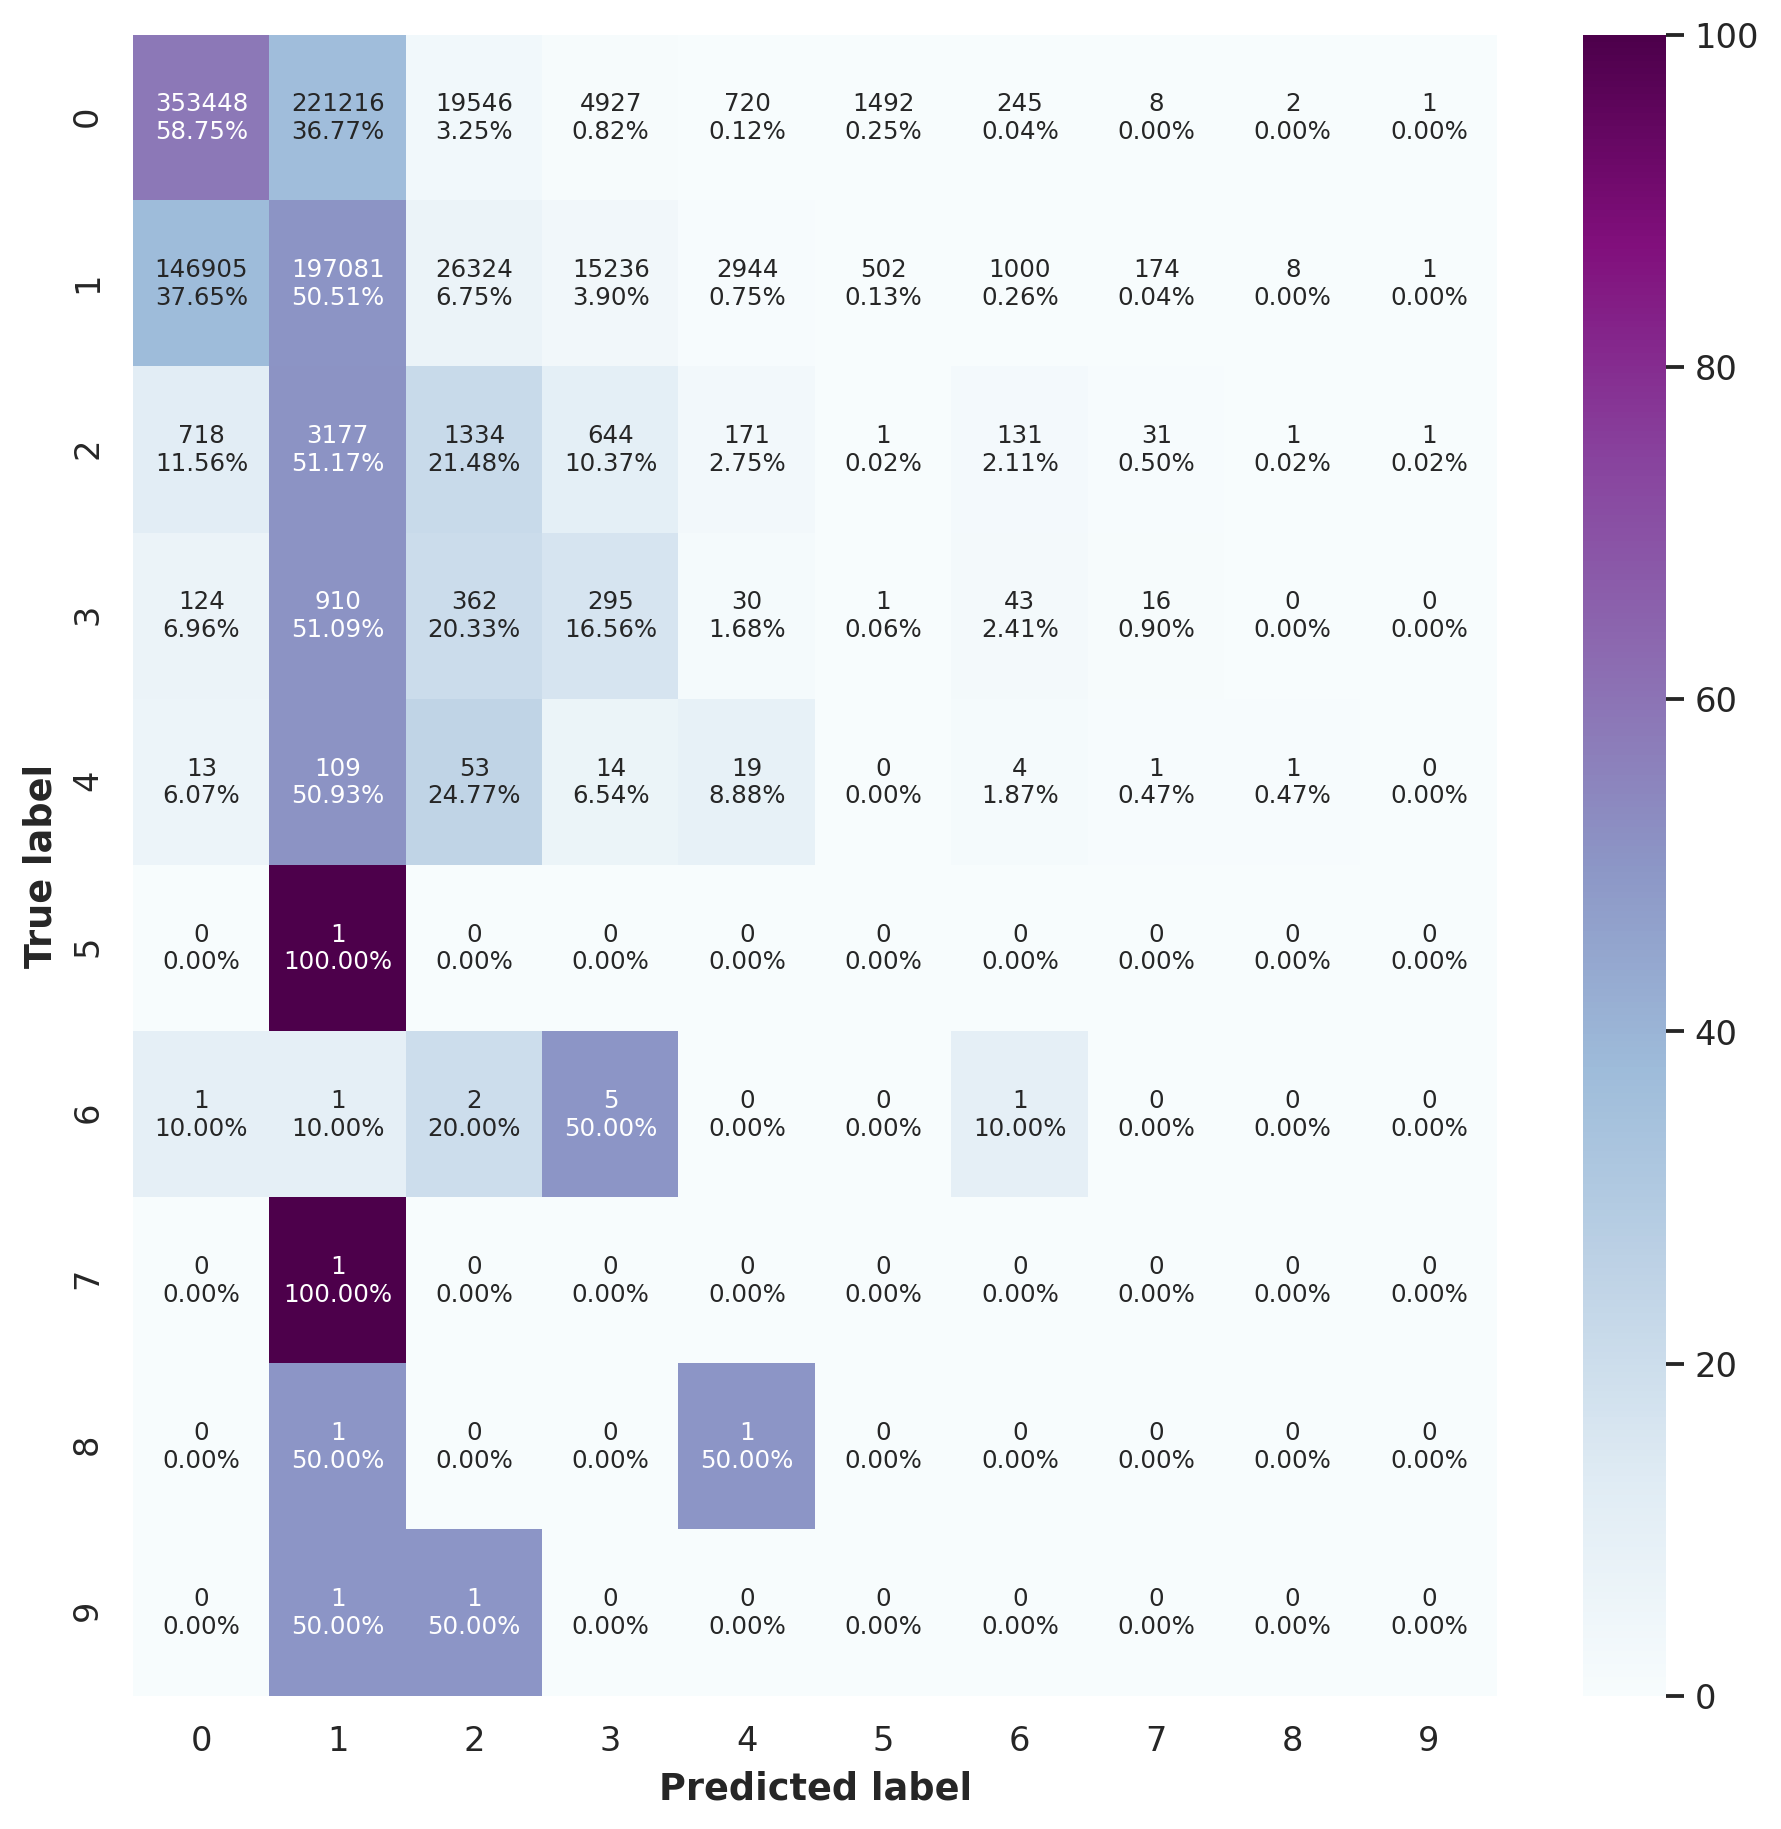

In [73]:
# correr primero la celda del final del notebook que define la funcion
plot_confusion_mat(pred_knn_only, y_validation)

Como sería la curva ROC para cada clase?

In [74]:
pred_prob_knn = knn_only.predict_proba(X_validation)

<Figure size 432x288 with 0 Axes>

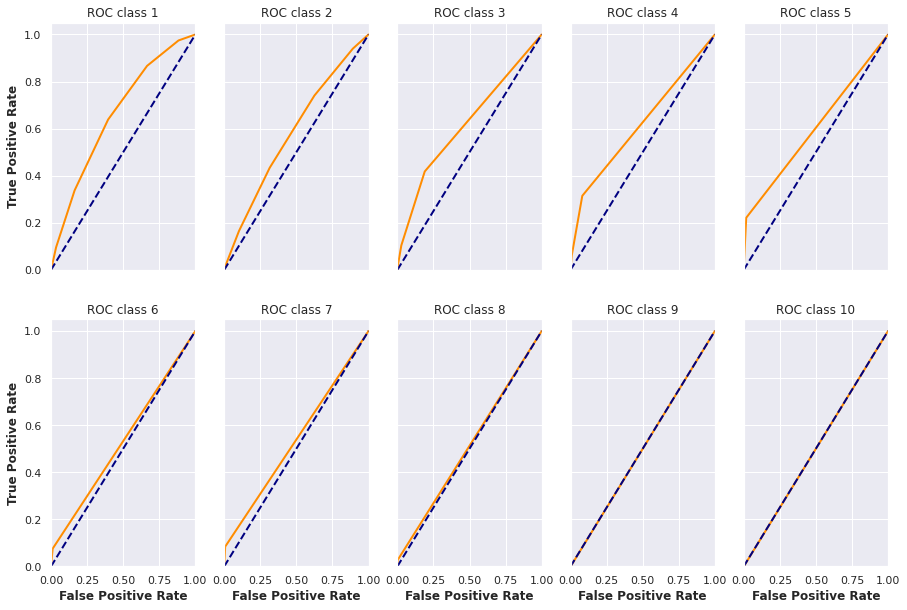

In [75]:
plot, knn_roc = roc_multiclass(pred_prob_knn, y_validation, 0)

In [76]:
knn_roc

0.5665886434406737

Entrenamos un modelo de Random Forest solo:

In [77]:
rf_only = RandomForestClassifier()
rf_only.fit(X_train, y_train)
pred_prob_rf = rf_only.predict_proba(X_validation)

<Figure size 432x288 with 0 Axes>

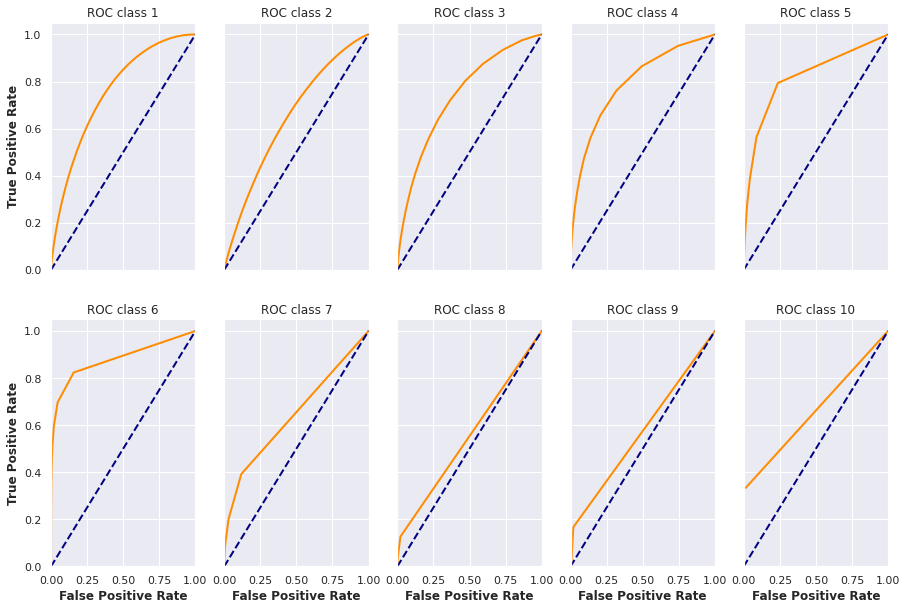

In [78]:
plot, random_forest_roc = roc_multiclass(pred_prob_rf, y_validation, 0)

In [79]:
random_forest_roc

0.7065361709029848

Evaluamos un modelo tipo stack:

In [80]:
if long_run:
    stacking_model.fit(X_train, y_train)
    pred_prob_stack = stacking_model.predict_proba(X_validation)
    plot, stacking_roc = roc_multiclass(pred_prob_stack, y_validation, 0)
    print(stacking_roc)
    print(
    "Accurary \nKnn solo: {:.2f} \nRandom forest solo: {:.2f} \nStacking: {:.3f}".format(
        knn_roc, random_forest_roc, stacking_roc
    )
)

Vemos que el modelo de tipo stack tiene mayor ROC.

### Voting
Vamos a ver como sería un modelo de votación clasificando los datos anteriores. Usamos un [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

In [81]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [82]:
clf_1 = KNeighborsClassifier()

In [83]:
clf_2 = DecisionTreeClassifier()

In [84]:
clf_3 = SVC(probability=True)

In [85]:
clf = VotingClassifier(
    estimators=[('clf_1', clf_1), ('clf_2', clf_2), ('clf_3', clf_3)], voting='soft'
)

In [86]:
clf_1.fit(X_train, y_train)

KNeighborsClassifier()

In [87]:
prob_pred_clf_1 = clf_1.predict_proba(X_validation)

<Figure size 432x288 with 0 Axes>

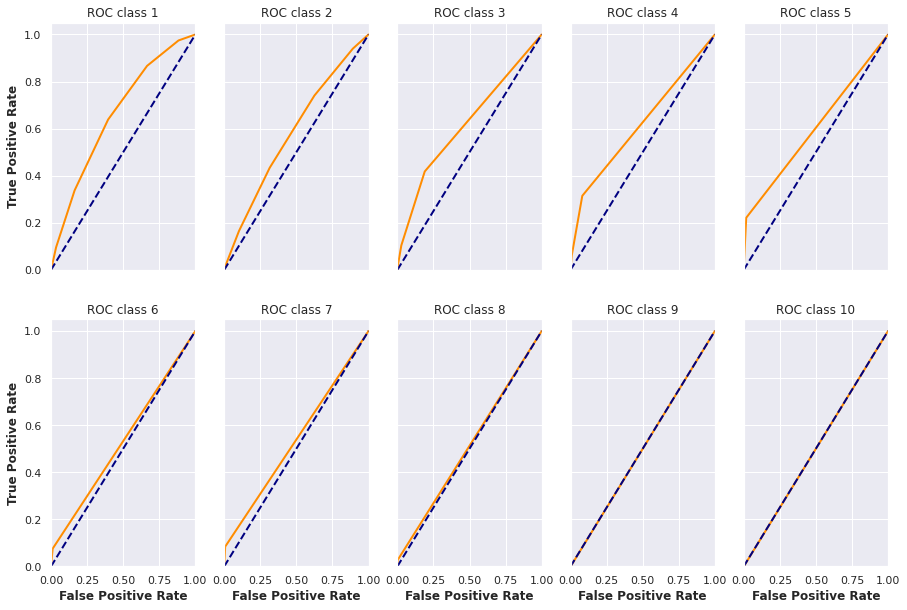

In [88]:
plot, knn_roc = roc_multiclass(prob_pred_clf_1, y_validation, 0)

In [89]:
knn_roc

0.5665886434406737

In [90]:
clf_2.fit(X_train, y_train)

DecisionTreeClassifier()

In [91]:
prob_pred_clf_2 = clf_2.predict_proba(X_validation)

<Figure size 432x288 with 0 Axes>

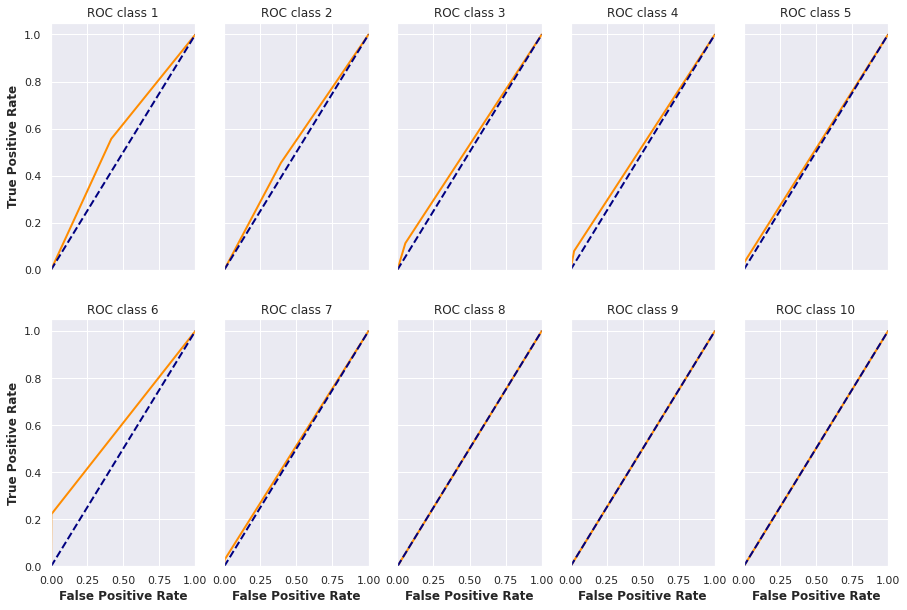

In [92]:
plot, decision_tree_roc = roc_multiclass(prob_pred_clf_2, y_validation, 0)

In [93]:
decision_tree_roc

0.5293391744361455

las siguientes celdas tardan 3 eternidades

In [94]:
if long_run:
    
    clf_3.fit(X_train, y_train)
    pred_clf_3 = clf_3.predict_proba(X_validation)
    plot, SVC_roc = roc_multiclass(pred_clf_3, y_validation, 0)
    print(SVC_roc)

Entrenamos el modelo de votacion:

In [95]:
if long_run:
    clf.fit(X_train, y_train)
    prob_pred_clf = clf.predict_proba(X_validation)
    plot, voting_roc = roc_multiclass(prob_pred_clf, y_validation, 0)
    print(voting_roc)
    print(
    "Accurary \nKnn solo: {:.2f} \nRandom forest solo: {:.2f} \nStacking: {:.3f}".format(
        knn_roc, random_forest_roc, voting_roc
    )
)

## Cascading

In [96]:
tree_model = RandomForestClassifier()
tree_model.fit(X_train, y_train)

RandomForestClassifier()

In [97]:
prob_pred_tree = tree_model.predict_proba(X_validation)

<Figure size 432x288 with 0 Axes>

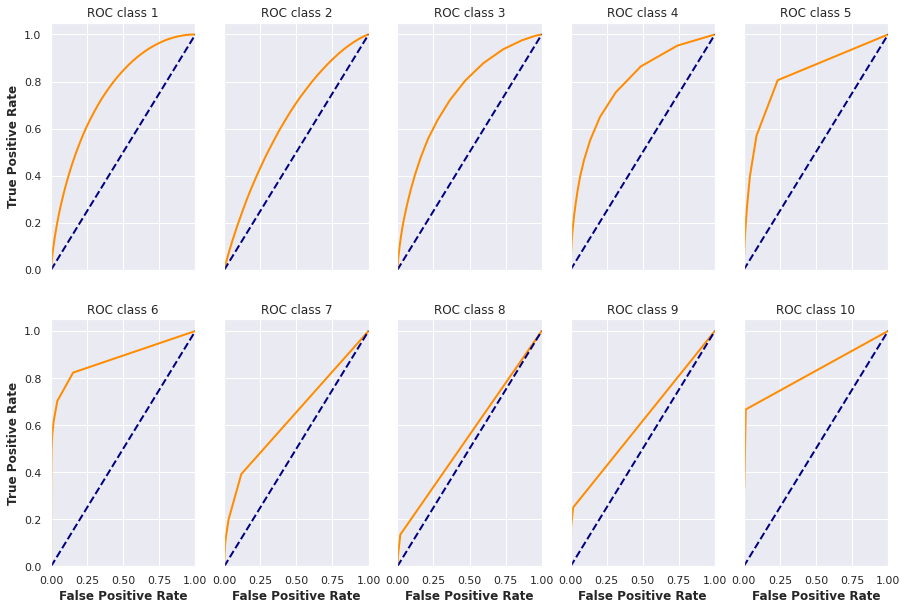

In [98]:
plot, voting_roc = roc_multiclass(prob_pred_tree, y_validation, 0)

In [99]:
tree_output = tree_model.predict_proba(X_train)

In [100]:
tree_output

array([[0.09, 0.14, 0.01, ..., 0.  , 0.01, 0.67],
       [0.16, 0.21, 0.  , ..., 0.  , 0.  , 0.63],
       [0.11, 0.22, 0.02, ..., 0.  , 0.  , 0.59],
       ...,
       [0.13, 0.82, 0.03, ..., 0.01, 0.  , 0.  ],
       [0.22, 0.78, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.21, 0.79, 0.  , ..., 0.  , 0.  , 0.  ]])

In [101]:
tree_output[0]

array([0.09, 0.14, 0.01, 0.  , 0.02, 0.06, 0.  , 0.  , 0.01, 0.67])

In [102]:
sure_points_index = []
threshold = 0.8  # cuan seguro quiero que este mi modelo
for i in range(len(tree_output)):
    if sum(tree_output[i] > threshold):
        sure_points_index.append(i)

In [103]:
len(sure_points_index) / len(tree_output)

0.5609756097560976

In [104]:
not_so_sure_points_index = []
for i in range(len(tree_output)):
    if i not in sure_points_index:
        not_so_sure_points_index.append(i)

In [105]:
SVC_model = SVC(probability=True)

In [106]:
X_train_boosting = X_train.values[not_so_sure_points_index]
y_train_boosting = y_train.values[not_so_sure_points_index]

In [107]:
pd.DataFrame(y_train_boosting)[0].value_counts()

1    5700
0    3375
2    1196
3     511
4      93
5      53
6      36
7       6
9       5
8       5
Name: 0, dtype: int64

In [108]:
if long_run:
    boosting_model.fit(X_train,y_train)
    SVC_model.fit(X_train, y_train)

### Evaluación del modelo de cascading

In [109]:
tree_output_validation = tree_model.predict_proba(X_validation)

In [110]:
sure_points_index_validation = []
for i in range(len(X_validation)):
    if sum(tree_output_validation[i] > threshold):
        sure_points_index_validation.append(i)

In [111]:
X_validation_tree_model = X_validation.values[sure_points_index_validation]
y_validation_tree_model = tree_model.predict(X_validation_tree_model)
accuracy_score(
    y_validation.values[sure_points_index_validation], y_validation_tree_model
)

0.9230769230769231

In [112]:
points_for_the_second_model_index = []
for i in range(len(X_validation)):
    if i not in sure_points_index_validation:
        points_for_the_second_model_index.append(i)

In [113]:
remaining_points = X_validation.values[points_for_the_second_model_index]

In [114]:
if long_run:
    y_final_output = SVC_model.predict(remaining_points)
    y_validation_remaining_points = y_validation[points_for_the_second_model_index]
    accuracy_score(y_final_output, y_validation_remaining_points)
    svc_pred = SVC_model.predict_proba(remaining_points)
    y_pred_cascading = np.concatenate((sure_points_tree_validation_probs, svc_pred))
    y_labels_cascading = np.concatenate(
    (y_validation[sure_points_index_validation], y_validation_remaining_points))
    plot, voting_roc = roc_multiclass(y_pred_cascading, y_labels_cascading, 0)